# 用 tifffile 读取 QPTIFF 多通道中心区域（按 .ppr 区分）

- 仅使用 `tifffile` 读取最高分辨率（level=0）的中心区域。
- 通过 `.ppr` 的 `BandNames` 区分每个通道，并按英文标题展示灰度图。
- 控制台输出使用分隔标记（中文），绘图标题用英文；用 OpenCV 进行可视化叠加。


In [2]:
print("_____")
print("[INFO] 环境与依赖导入")
print("_____")
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

try:
    import tifffile as tiff
    has_tifffile = True
except Exception as e:
    has_tifffile = False
    print("_____")
    print("[ERROR] tifffile 导入失败:", e)
    print("[HINT] 请安装 Python 包 tifffile")
    print("_____")

print("_____")
print("[INFO] has_tifffile =", has_tifffile)
print("_____")


_____
[INFO] 环境与依赖导入
_____
_____
[INFO] has_tifffile = True
_____


In [3]:
# 可选依赖：zarr（用于按块读取）
import zarr
has_zarr = True

print("_____")
print("[INFO] has_zarr =", has_zarr)
print("_____")


_____
[INFO] has_zarr = True
_____


In [4]:
# 路径与读取配置
QPTIFF_PATH = "/nfs5/yj/MIHC/dataset/KidneyCancer/NO2/11/Scan1/11_Scan1.qptiff"
PPR_PATH = "/nfs5/yj/MIHC/dataset/KidneyCancer/NO2/11.ppr"
PATCH_SIZE = 1024  # 在最高层级读取的中心区域尺寸

print("_____")
print("[INFO] 目标 qptiff:", QPTIFF_PATH)
print("[INFO] 对应 ppr:", PPR_PATH)
print("[INFO] 读取区域尺寸:", PATCH_SIZE)
print("_____")

if not os.path.exists(QPTIFF_PATH):
    print("_____")
    print("[ERROR] 文件不存在——请检查 qptiff 路径。")
    print("_____")
    raise FileNotFoundError(QPTIFF_PATH)
if not os.path.exists(PPR_PATH):
    print("_____")
    print("[WARN] 找不到 ppr 文件，将无法按 BandNames 标注通道。")
    print("_____")


_____
[INFO] 目标 qptiff: /nfs5/yj/MIHC/dataset/KidneyCancer/NO2/11/Scan1/11_Scan1.qptiff
[INFO] 对应 ppr: /nfs5/yj/MIHC/dataset/KidneyCancer/NO2/11.ppr
[INFO] 读取区域尺寸: 1024
_____


In [5]:
def parse_ppr(path):
    band_names = []
    meta = {}
    try:
        if not os.path.exists(path):
            return meta, band_names
        with open(path, 'r', encoding='utf-8', errors='ignore') as f:
            for line in f:
                line = line.strip()
                if not line or line.startswith('#'):
                    continue
                k, _, v = line.partition('=')
                meta[k.strip()] = v.strip()
        band_names = [b.strip() for b in meta.get('BandNames', '').split(',') if b.strip()]
    except Exception as e:
        print("_____")
        print("[WARN] 解析 ppr 失败:", e)
        print("_____")
    return meta, band_names

def show_rgb(img_rgb, title=""):
    plt.figure(figsize=(6,6))
    plt.imshow(img_rgb, cmap=None)
    plt.title(title)
    plt.axis('off')
    plt.show()

def draw_rect_on_thumb(thumb_rgb, full_w, full_h, x0, y0, w, h):
    th_h, th_w = thumb_rgb.shape[0], thumb_rgb.shape[1]
    sx = th_w / float(full_w)
    sy = th_h / float(full_h)
    rx0 = int(x0 * sx)
    ry0 = int(y0 * sy)
    rw = int(w * sx)
    rh = int(h * sy)
    bgr = cv2.cvtColor(thumb_rgb, cv2.COLOR_RGB2BGR)
    cv2.rectangle(bgr, (rx0, ry0), (rx0+rw, ry0+rh), (0,255,0), 2)
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

def normalize_to_uint8(img):
    # 将任意灰度图归一化到 0-255 以便显示
    if img.dtype == np.uint8:
        return img
    img = np.asarray(img)
    minv = float(np.min(img))
    maxv = float(np.max(img))
    if maxv > minv:
        out = (img - minv) / (maxv - minv)
    else:
        out = img * 0
    out = (out * 255.0).clip(0, 255).astype(np.uint8)
    return out


_____
[INFO] 解析 PPR 以获取 BandNames
_____
[INFO] BandNames 数量: 0
[INFO] BandNames: []
_____
[INFO] 使用 tifffile 打开 qptiff 并枚举最高层级
_____
[INFO] series 数量: 4
[INFO] series 0 axes= CYX shape= (8, 50400, 34560)
[INFO] series 1 axes= YXS shape= (393, 270, 3)
[INFO] series 2 axes= YXS shape= (3957, 2049, 3)
[INFO] series 3 axes= YXS shape= (441, 512, 3)
[INFO] 识别到通道数: 17
[INFO] level0 尺寸: (34560, 50400)
[INFO] 中心区域坐标: (16768, 24688, 17792, 25712)


/tmp/ipykernel_908691/921068769.py:111: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axes[r, c].imshow(patch_u8, cmap='gray')
/tmp/ipykernel_908691/921068769.py:111: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[r, c].imshow(patch_u8, cmap='gray')


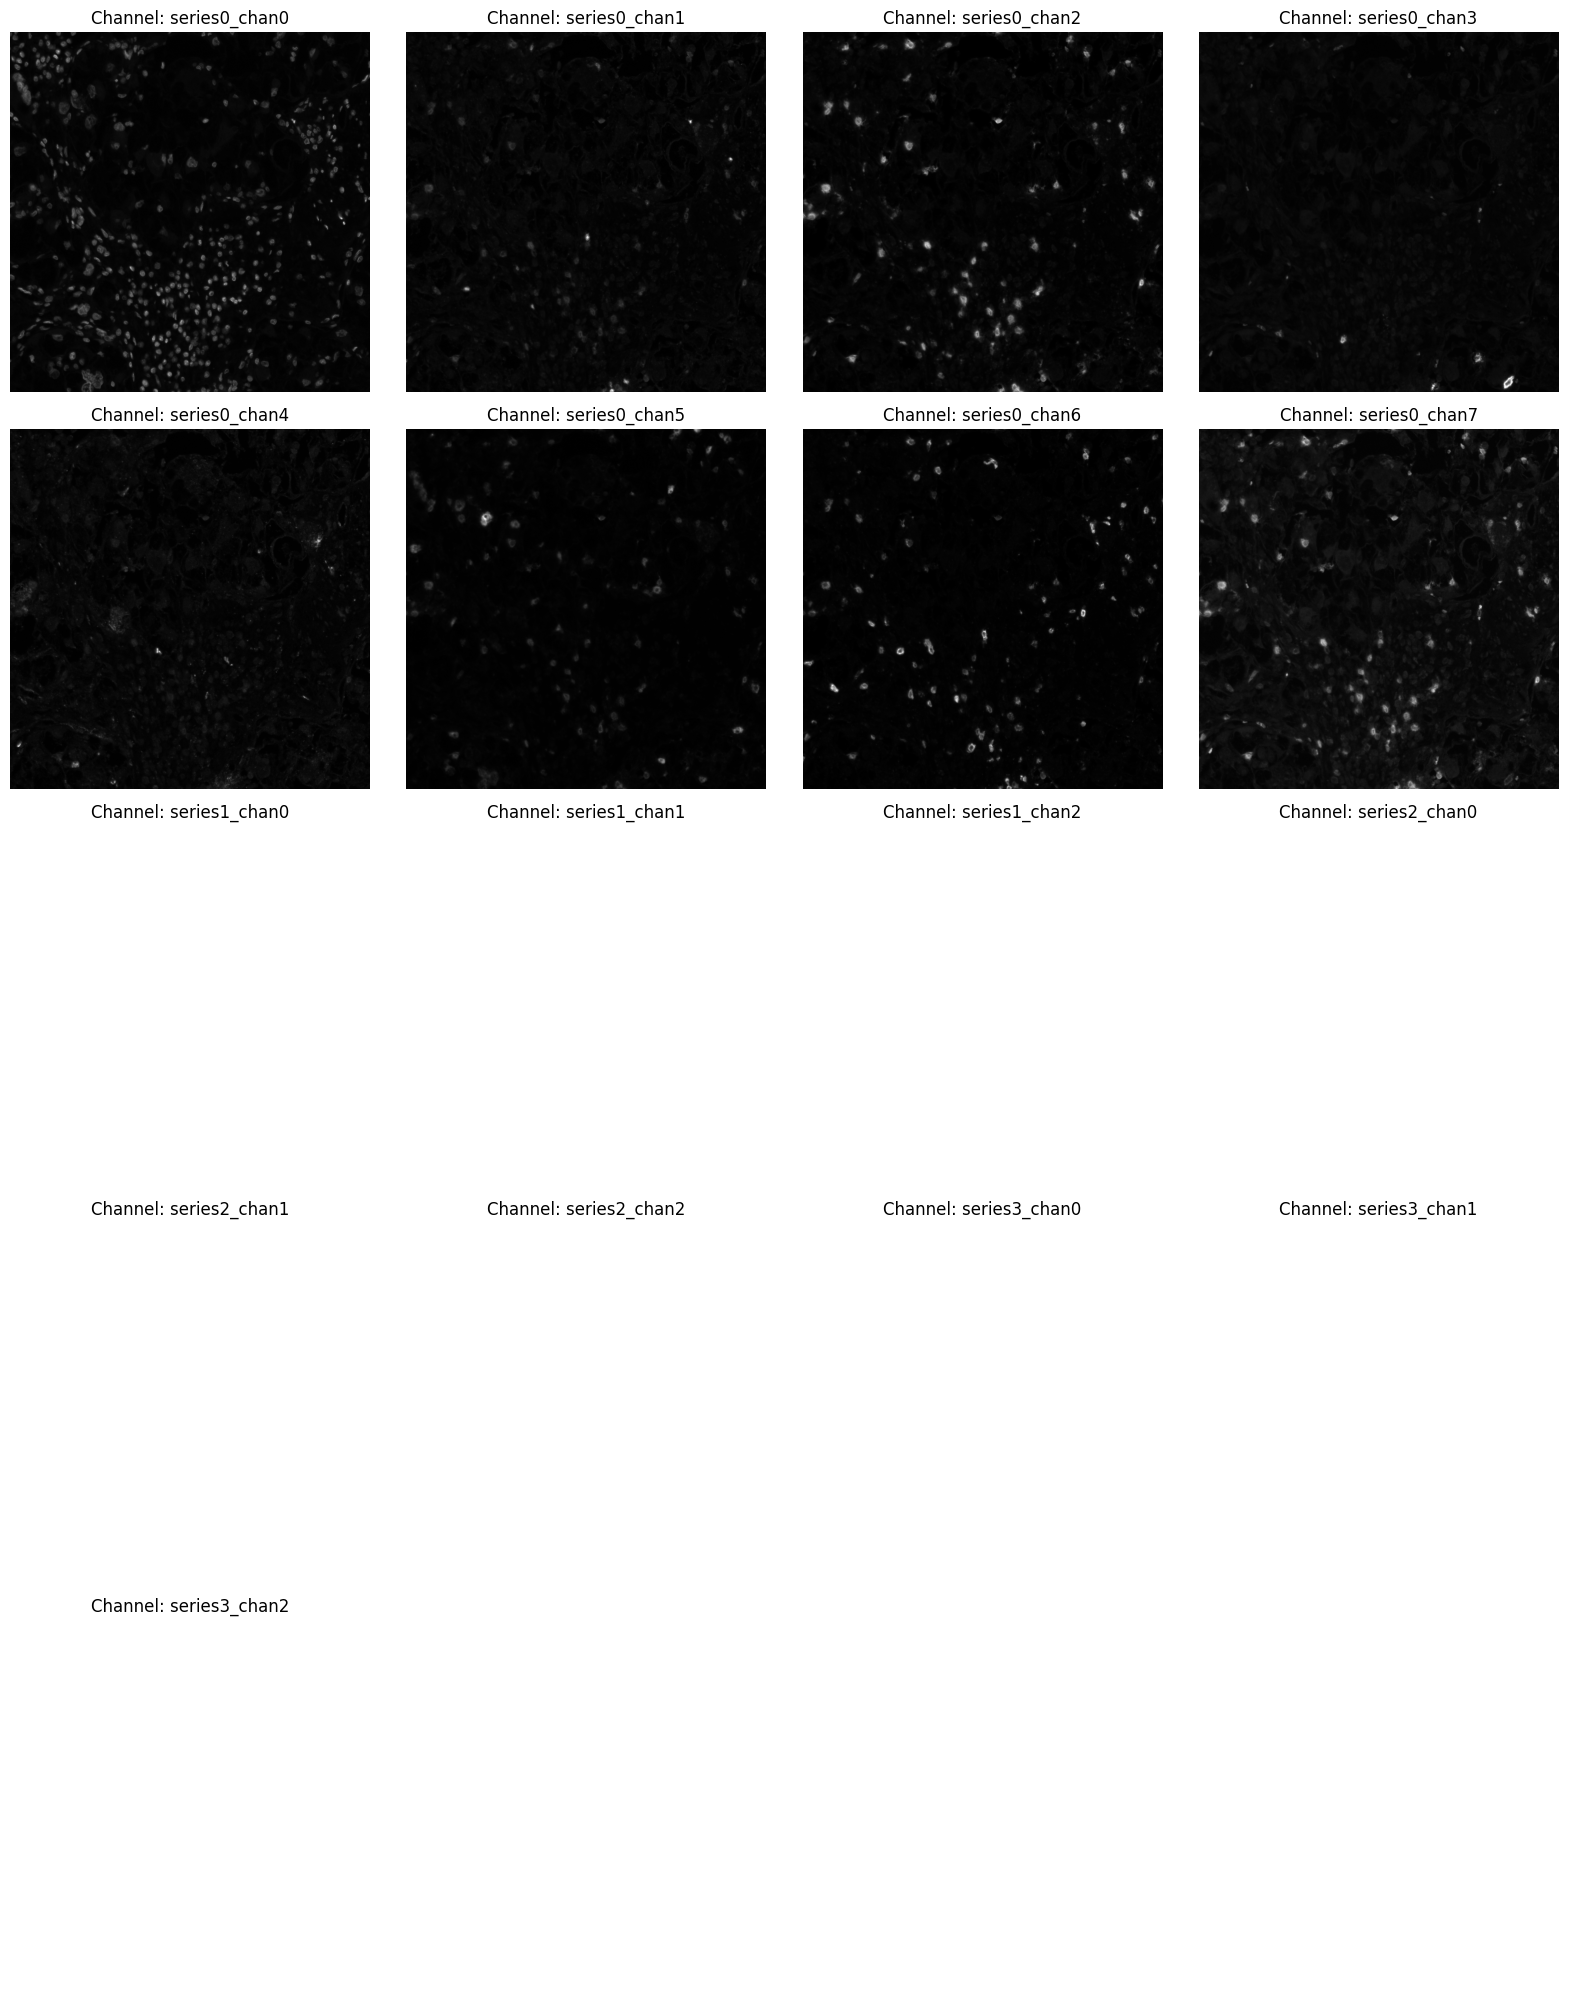

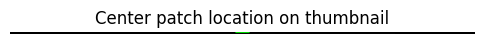

[INFO] level0 尺寸: (34560, 50400)
[INFO] 中心区域坐标: (16768, 24688, 17792, 25712)


/tmp/ipykernel_908691/921068769.py:194: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axes[r, c].imshow(patch_u8, cmap='gray')
/tmp/ipykernel_908691/921068769.py:194: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[r, c].imshow(patch_u8, cmap='gray')


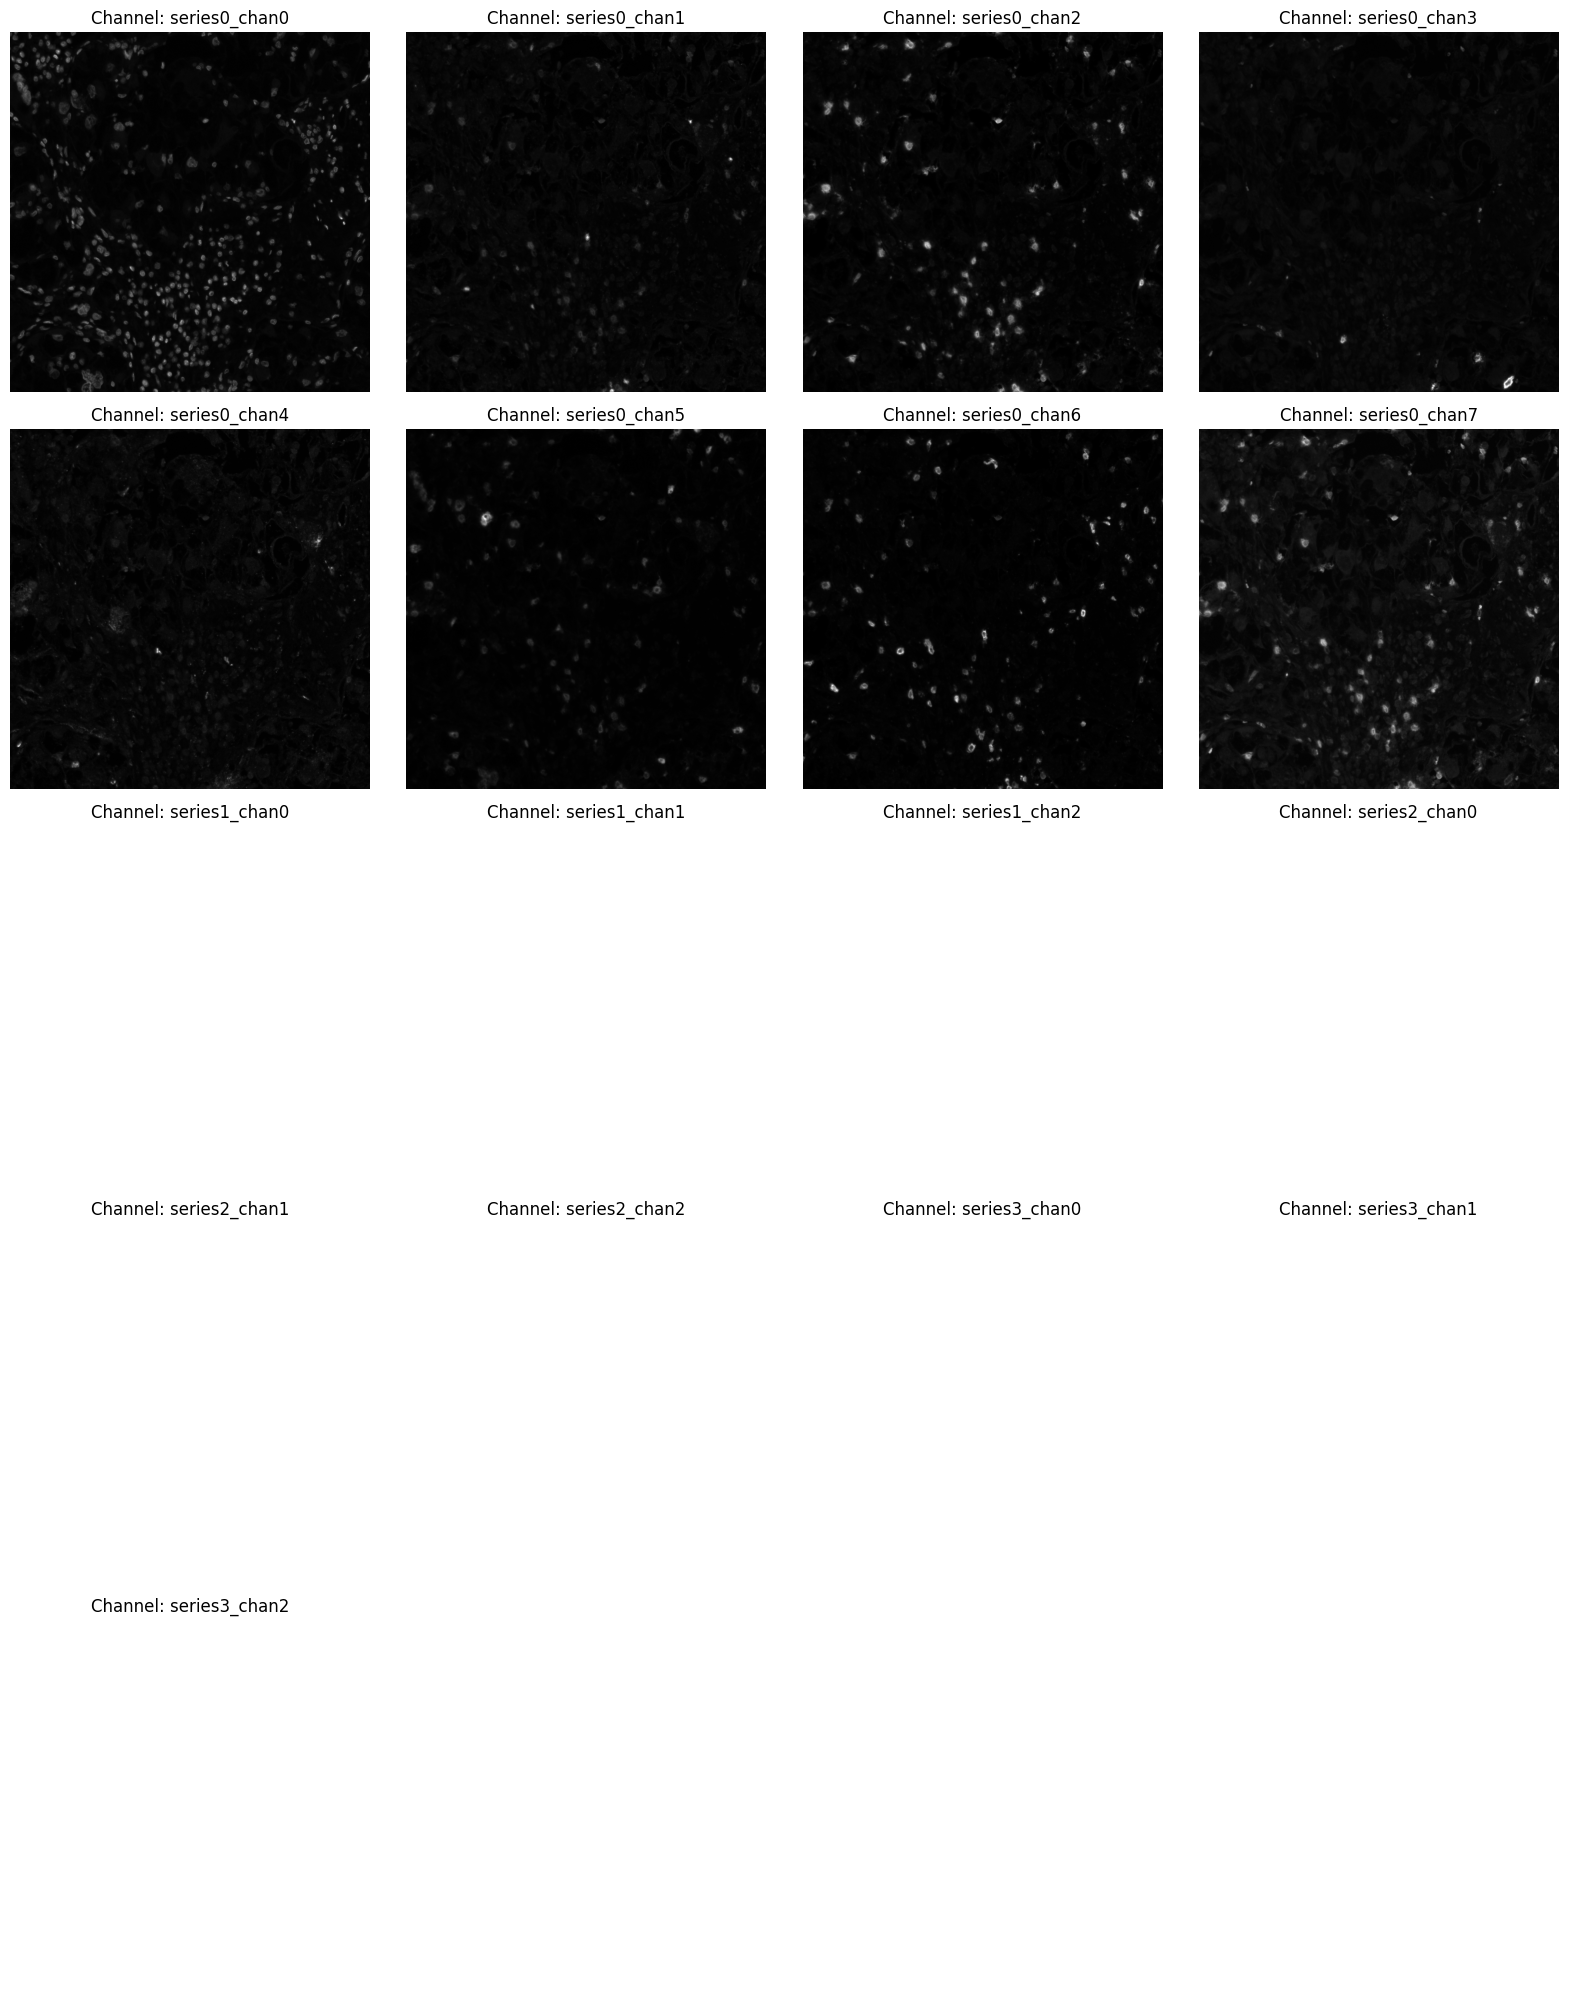

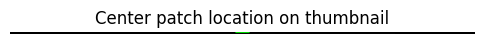

In [6]:
if not has_tifffile:
    raise RuntimeError("tifffile 不可用，无法继续。")
# 必须使用 zarr，移除整体载入回退
if not has_zarr:
    print("_____")
    print("[ERROR] 缺少 zarr，无法按块读取，请先安装。")
    print("_____")
    raise RuntimeError("缺少 zarr 依赖")

print("_____")
print("[INFO] 解析 PPR 以获取 BandNames")
print("_____")
meta, band_names = parse_ppr(PPR_PATH)
print("[INFO] BandNames 数量:", len(band_names))
print("[INFO] BandNames:", band_names)

print("_____")
print("[INFO] 使用 tifffile 打开 qptiff 并枚举最高层级")
print("_____")
with tiff.TiffFile(QPTIFF_PATH) as tf:
    nseries = len(tf.series)
    print("[INFO] series 数量:", nseries)
    channels = []  # 每个元素: dict(name, arr, shape)
    for si, s in enumerate(tf.series):
        lvl0 = s.levels[0]
        axes = getattr(lvl0, 'axes', '')
        shape = lvl0.shape
        print("[INFO] series", si, "axes=", axes, "shape=", shape)
        # 打开最高层级数组：仅使用 aszarr + zarr
        arr = s.aszarr(level=0)
        try:
            _ = arr.ndim
        except AttributeError:
            import zarr as _z
            arr = _z.open(arr)
        axes_str = axes if isinstance(axes, str) and axes else ''
        ch_char = 'C' if 'C' in axes_str else ('S' if 'S' in axes_str else None)
        ch_idx = axes_str.find(ch_char) if ch_char else None
        # 如果存在通道维度（C 或 S）且长度>1，则按通道拆分
        if ch_idx is not None and shape[ch_idx] > 1:
            for c in range(shape[ch_idx]):
                channels.append({"name": f"series{si}_chan{c}", "arr": arr, "chan_index": c, "axes": axes, "shape": shape})
        else:
            # 2D 灰度（常见于每通道独立 series 或单通道）
            channels.append({"name": f"series{si}", "arr": arr, "axes": axes, "shape": shape})

    nch = len(channels)
    print("[INFO] 识别到通道数:", nch)
    
    # 尝试用 BandNames 覆盖通道名：仅当某 series 的通道数与 BandNames 匹配时
    if len(band_names) > 0:
        # 统计第一个具有通道维度的 series 的通道数
        series_ch_count = None
        for si, s in enumerate(tf.series):
            axes = getattr(s.levels[0], 'axes', '')
            shape = s.levels[0].shape
            axes_str = axes if isinstance(axes, str) and axes else ''
            ch_char = 'C' if 'C' in axes_str else ('S' if 'S' in axes_str else None)
            ch_idx = axes_str.find(ch_char) if ch_char else None
            if ch_idx is not None and shape[ch_idx] > 1:
                series_ch_count = shape[ch_idx]
                break
        if series_ch_count == len(band_names):
            # 将具有 chan_index 的条目应用 BandNames
            for ch in channels:
                if 'chan_index' in ch:
                    ch['name'] = band_names[int(ch['chan_index'])]
            
    # 统一尺寸与中心坐标（以第一个通道为准）
    # 以第一个通道的 Y/X 维度确定整体尺寸
    axes0 = channels[0].get("axes", '')
    shape0 = channels[0]["shape"]
    axstr = axes0 if isinstance(axes0, str) and axes0 else ''
    y_idx0 = axstr.find('Y') if 'Y' in axstr else 0
    x_idx0 = axstr.find('X') if 'X' in axstr else 1
    full_h, full_w = shape0[y_idx0], shape0[x_idx0]
    patch_w = patch_h = int(PATCH_SIZE)
    x0 = max(0, int(full_w/2 - patch_w/2))
    y0 = max(0, int(full_h/2 - patch_h/2))
    x1 = min(full_w, x0 + patch_w)
    y1 = min(full_h, y0 + patch_h)
    print("[INFO] level0 尺寸:", (full_w, full_h))
    print("[INFO] 中心区域坐标:", (x0, y0, x1, y1))

    # 可视化所有通道的中心区域灰度图（英文标题）
    ncols = 4
    nrows = int(math.ceil(nch / float(ncols)))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = np.array(axes).reshape(nrows, ncols)
    for idx, ch in enumerate(channels):
        r = idx // ncols
        c = idx % ncols
        arr = ch["arr"]
        axes_str = ch.get("axes", '')
        shape = ch["shape"]
        y_idx = axes_str.find('Y') if 'Y' in axes_str else 0
        x_idx = axes_str.find('X') if 'X' in axes_str else 1
        ch_idx = None
        if isinstance(axes_str, str):
            if 'C' in axes_str:
                ch_idx = axes_str.find('C')
            elif 'S' in axes_str:
                ch_idx = axes_str.find('S')
        slices = [slice(None)] * arr.ndim
        slices[y_idx] = slice(y0, y1)
        slices[x_idx] = slice(x0, x1)
        if ch_idx is not None and 'chan_index' in ch:
            slices[ch_idx] = ch["chan_index"]
        patch = np.array(arr[tuple(slices)])
        patch_u8 = normalize_to_uint8(patch)
        axes[r, c].imshow(patch_u8, cmap='gray')
        axes[r, c].set_title(f"Channel: {ch['name']}")
        axes[r, c].axis('off')
    # 关闭空白子图
    for idx in range(nch, nrows*ncols):
        r = idx // ncols
        c = idx % ncols
        axes[r, c].axis('off')
    plt.tight_layout()
    plt.show()

    # 生成缩略图并在其上叠加中心区域位置（以第一个通道最低层级为缩略图）
    thumb_arr = np.array(tf.series[0].levels[-1].asarray())
    if thumb_arr.ndim == 2:
        thumb_rgb = cv2.cvtColor(normalize_to_uint8(thumb_arr), cv2.COLOR_GRAY2RGB)
    else:
        # 若最低层级带样本维度，取第一个样本并转 RGB（若已是 RGB 则直接用）
        th = thumb_arr[..., 0] if thumb_arr.shape[-1] > 1 else thumb_arr
        thumb_rgb = cv2.cvtColor(normalize_to_uint8(th), cv2.COLOR_GRAY2RGB)
    overlay = draw_rect_on_thumb(thumb_rgb, full_w, full_h, x0, y0, (x1-x0), (y1-y0))
    show_rgb(overlay, title="Center patch location on thumbnail")

    # 尝试用 BandNames 覆盖通道名：仅当某 series 的通道数与 BandNames 匹配时
    if len(band_names) > 0:
        # 统计第一个具有通道维度的 series 的通道数
        series_ch_count = None
        for si, s in enumerate(tf.series):
            axes = getattr(s.levels[0], 'axes', '')
            shape = s.levels[0].shape
            axes_str = axes if isinstance(axes, str) and axes else ''
            ch_char = 'C' if 'C' in axes_str else ('S' if 'S' in axes_str else None)
            ch_idx = axes_str.find(ch_char) if ch_char else None
            if ch_idx is not None and shape[ch_idx] > 1:
                series_ch_count = shape[ch_idx]
                break
        if series_ch_count == len(band_names):
            # 将具有 chan_index 的条目应用 BandNames
            for ch in channels:
                if 'chan_index' in ch:
                    ch['name'] = band_names[int(ch['chan_index'])]
            
    # 统一尺寸与中心坐标（以第一个通道为准）
    # 以第一个通道的 Y/X 维度确定整体尺寸
    axes0 = channels[0].get("axes", '')
    shape0 = channels[0]["shape"]
    axstr = axes0 if isinstance(axes0, str) and axes0 else ''
    y_idx0 = axstr.find('Y') if 'Y' in axstr else 0
    x_idx0 = axstr.find('X') if 'X' in axstr else 1
    full_h, full_w = shape0[y_idx0], shape0[x_idx0]
    patch_w = patch_h = int(PATCH_SIZE)
    x0 = max(0, int(full_w/2 - patch_w/2))
    y0 = max(0, int(full_h/2 - patch_h/2))
    x1 = min(full_w, x0 + patch_w)
    y1 = min(full_h, y0 + patch_h)
    print("[INFO] level0 尺寸:", (full_w, full_h))
    print("[INFO] 中心区域坐标:", (x0, y0, x1, y1))

    # 可视化所有通道的中心区域灰度图（英文标题）
    ncols = 4
    nrows = int(math.ceil(nch / float(ncols)))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = np.array(axes).reshape(nrows, ncols)
    for idx, ch in enumerate(channels):
        r = idx // ncols
        c = idx % ncols
        arr = ch["arr"]
        axes_str = ch.get("axes", '')
        shape = ch["shape"]
        y_idx = axes_str.find('Y') if 'Y' in axes_str else 0
        x_idx = axes_str.find('X') if 'X' in axes_str else 1
        ch_idx = None
        if isinstance(axes_str, str):
            if 'C' in axes_str:
                ch_idx = axes_str.find('C')
            elif 'S' in axes_str:
                ch_idx = axes_str.find('S')
        slices = [slice(None)] * arr.ndim
        slices[y_idx] = slice(y0, y1)
        slices[x_idx] = slice(x0, x1)
        if ch_idx is not None and 'chan_index' in ch:
            slices[ch_idx] = ch["chan_index"]
        patch = np.array(arr[tuple(slices)])
        patch_u8 = normalize_to_uint8(patch)
        axes[r, c].imshow(patch_u8, cmap='gray')
        axes[r, c].set_title(f"Channel: {ch['name']}")
        axes[r, c].axis('off')
    # 关闭空白子图
    for idx in range(nch, nrows*ncols):
        r = idx // ncols
        c = idx % ncols
        axes[r, c].axis('off')
    plt.tight_layout()
    plt.show()

    # 生成缩略图并在其上叠加中心区域位置（以第一个通道最低层级为缩略图）
    thumb_arr = np.array(tf.series[0].levels[-1].asarray())
    if thumb_arr.ndim == 2:
        thumb_rgb = cv2.cvtColor(normalize_to_uint8(thumb_arr), cv2.COLOR_GRAY2RGB)
    else:
        # 若最低层级带样本维度，取第一个样本并转 RGB（若已是 RGB 则直接用）
        th = thumb_arr[..., 0] if thumb_arr.shape[-1] > 1 else thumb_arr
        thumb_rgb = cv2.cvtColor(normalize_to_uint8(th), cv2.COLOR_GRAY2RGB)
    overlay = draw_rect_on_thumb(thumb_rgb, full_w, full_h, x0, y0, (x1-x0), (y1-y0))
    show_rgb(overlay, title="Center patch location on thumbnail")


In [7]:
# 交互式查看 cluster_map.tiff 中的 1024x1024 窗口（按需读取，不加载全图）

import os
import numpy as np
import matplotlib.pyplot as plt

try:
    import tifffile as tiff
    import zarr
    import ipywidgets as widgets
    from IPython.display import display
    has_ipywidgets = True
except Exception as e:
    print("_____")
    print("[ERROR] 交互可视化依赖导入失败:", e)
    print("[HINT] 请确保已安装: tifffile, zarr, ipywidgets")
    print("_____")
    has_ipywidgets = False

TIFF_PATH = "/nfs5/zyh/MUF-Clust/single_image_output/segmentation/11_Scan1/features/features_matrix_mean_cluster_cluster_map.tiff"
PATCH_SIZE = 1024

print("_____")
print("[INFO] 目标 tiff:", TIFF_PATH)
print("[INFO] PATCH_SIZE:", PATCH_SIZE)
print("_____")

if not os.path.exists(TIFF_PATH):
    print("_____")
    print("[ERROR] 文件不存在——请检查 TIFF_PATH")
    print("_____")
else:
    if not has_ipywidgets:
        raise RuntimeError("缺少 ipywidgets 或 tifffile/zarr，无法进行交互式可视化")

    with tiff.TiffFile(TIFF_PATH) as tf:
        s = tf.series[0]
        arr = s.aszarr()
        try:
            _ = arr.ndim
        except AttributeError:
            arr = zarr.open(arr)

        # 处理 2D 或 3D 情况：
        # - 2D: (Y, X)
        # - 3D: (C, Y, X) 或 (Z, Y, X)，此时固定第 0 个切片/通道
        if arr.ndim == 2:
            H, W = arr.shape
            fixed_index = None
        elif arr.ndim == 3:
            H, W = arr.shape[-2], arr.shape[-1]
            fixed_index = 0
        else:
            raise RuntimeError(f"不支持的维度: {arr.shape}")

        max_x = max(0, W - PATCH_SIZE)
        max_y = max(0, H - PATCH_SIZE)

        print("[INFO] 图像尺寸 (W, H):", (W, H))
        print("[INFO] 滑块范围: x ∈ [0,", max_x, "], y ∈ [0,", max_y, "]")

        def show_patch(x, y):
            x = int(x)
            y = int(y)
            x = min(max(x, 0), max_x)
            y = min(max(y, 0), max_y)

            if arr.ndim == 2:
                patch = np.array(arr[y:y+PATCH_SIZE, x:x+PATCH_SIZE])
            else:
                patch = np.array(arr[fixed_index, y:y+PATCH_SIZE, x:x+PATCH_SIZE])

            plt.figure(figsize=(6, 6))
            # 对于 cluster_map 一般是整数标签，这里用离散 colormap
            plt.imshow(patch, cmap="tab20")
            plt.title(f"x={x}, y={y}, size={PATCH_SIZE}x{PATCH_SIZE}")
            plt.axis("off")
            plt.show()

        x_slider = widgets.IntSlider(
            value=0,
            min=0,
            max=max_x,
            step=max(1, PATCH_SIZE // 4),
            description="x",
            continuous_update=False,
        )
        y_slider = widgets.IntSlider(
            value=0,
            min=0,
            max=max_y,
            step=max(1, PATCH_SIZE // 4),
            description="y",
            continuous_update=False,
        )

        ui = widgets.VBox([x_slider, y_slider])
        out = widgets.interactive_output(show_patch, {"x": x_slider, "y": y_slider})

        display(ui, out)

_____
[ERROR] 交互可视化依赖导入失败: No module named 'ipywidgets'
[HINT] 请确保已安装: tifffile, zarr, ipywidgets
_____
_____
[INFO] 目标 tiff: /nfs5/zyh/MUF-Clust/single_image_output/segmentation/11_Scan1/features/features_matrix_mean_cluster_cluster_map.tiff
[INFO] PATCH_SIZE: 1024
_____


RuntimeError: 缺少 ipywidgets 或 tifffile/zarr，无法进行交互式可视化